In [230]:
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
import imgaug as ia
import imgaug.augmenters as iaa
import torchmetrics
import math

# Batch Sampler

In [231]:
class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=True):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()


# ImageDataset function
Conmverts numpy arrays into datasets and can also convert them into torch tensors

In [232]:
class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


# Class labels

class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Training and test data

In [233]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [234]:
#@title
# Downloading the images:
train_x = np.load('./data_train_set.npy')
test_x = np.load('./data_test_set.npy')

# Data Augmentation

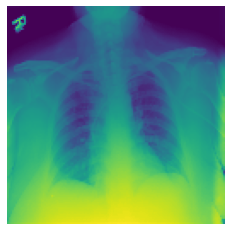

In [235]:
plt.imshow(train_x[0].squeeze())
plt.axis('off');

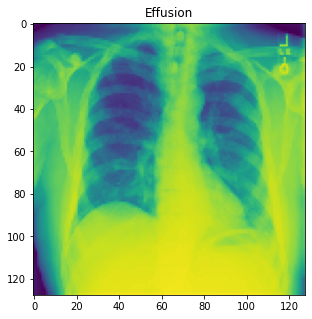

In [236]:
ax = plt.subplots(ncols= 1, figsize=[5,5])

image = 6
classification = class_labels[train_y[image]]

ax[1].imshow(train_x[image].squeeze())
ax[1].set_title(classification);

In [237]:

#for i in range(500):
    #classification = class_labels[train_y[i]]
    #plt.imshow(train_x[i].squeeze(), cmap='gray')
    #plt.axis('off')
    #plt.savefig('./train_images/{classification}/''{i}.png'''.format(i=i,classification=classification))


In [238]:
train_x.shape, test_x.shape

((16841, 1, 128, 128), (8420, 1, 128, 128))

In [239]:
from PIL import Image
from torchvision import datasets


def custom_pil_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


dataset = datasets.ImageFolder("./train_images", loader=custom_pil_loader, transform = transforms.Compose([
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.AutoAugment(),
    transforms.Resize((244,244)),
    transforms.ToTensor(),
    ]))
dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ./train_images
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Label : No Finding


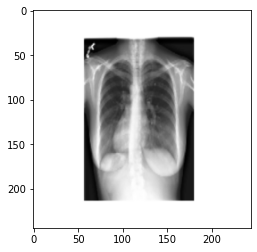

In [240]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[np.random.randint(0, len(dataset))])

In [241]:
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.RandomInvert(p=0.9),
    transforms.RandomAdjustSharpness(2, p=0.9),
    transforms.RandomRotation(270),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.CenterCrop((200,200)),
    transforms.AutoAugment(),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
])


# Data distribution

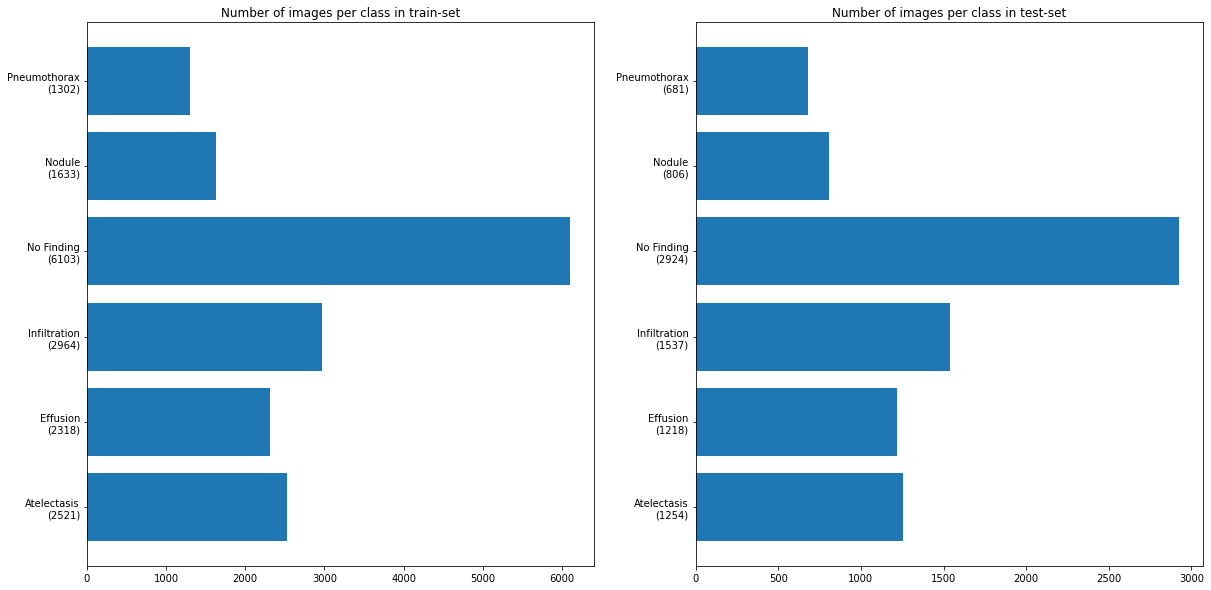

In [242]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

# Example images

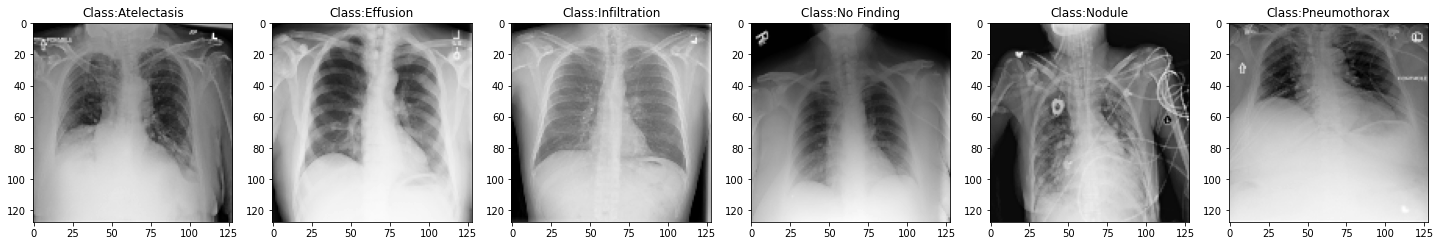

In [243]:
#@title
#Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Creating torch datasets and defining device

In [244]:
train_dataset = ImageDataset(train_x, train_y, transform=trans)
test_dataset = ImageDataset(test_x, test_y,transform=trans)

In [245]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device 

'cuda'

In [246]:
for i in tqdm(train_dataset):
    images, labels = i
    
    


100%|██████████| 16841/16841 [00:00<00:00, 24755.56it/s]


In [247]:
print(images.shape)

torch.Size([1, 128, 128])


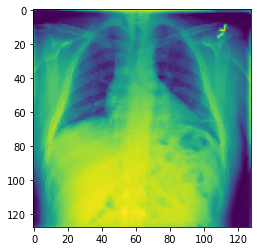

In [248]:
plt.imshow(images.squeeze());

# Neural Network

In [249]:

class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),
            torch.nn.Dropout(p=0.5, inplace=True),


            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            torch.nn.Dropout(p=0.25, inplace=True),
            
            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.125, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6).to(device)


In [250]:
summary(model, input_size=(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,088
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
           Dropout-5           [-1, 64, 31, 31]               0
            Conv2d-6           [-1, 32, 28, 28]          32,800
       BatchNorm2d-7           [-1, 32, 28, 28]              64
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9             [-1, 32, 9, 9]               0
          Dropout-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 16, 6, 6]           8,208
      BatchNorm2d-12             [-1, 16, 6, 6]              32
             ReLU-13             [-1, 16, 6, 6]               0
        MaxPool2d-14             [-1, 1

# Optimizer and Loss functions

In [251]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training and Testing definitions

In [252]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

# Training and test procedures

In [253]:
n_epochs = 10
batch_size =25

In [254]:
torch.cuda.empty_cache()
import gc
gc.collect()

9192

100%|██████████| 674/674 [00:07<00:00, 85.88it/s]



Epoch 1 training done, loss on train set: 1.611463189125061



100%|██████████| 85/85 [00:01<00:00, 64.73it/s]


Epoch 1 testing done, loss on test set: 1.619370460510254



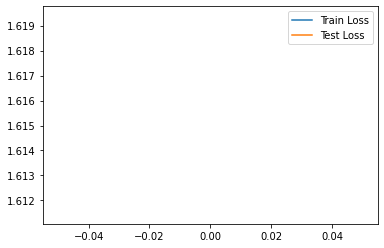

100%|██████████| 674/674 [00:09<00:00, 69.34it/s]



Epoch 2 training done, loss on train set: 1.5701297521591187



100%|██████████| 85/85 [00:02<00:00, 36.54it/s]



Epoch 2 testing done, loss on test set: 1.5733718872070312



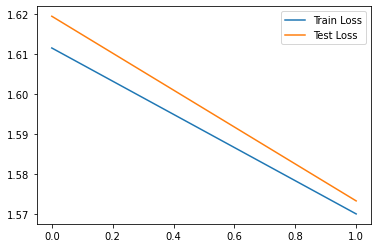

100%|██████████| 674/674 [00:09<00:00, 74.28it/s]



Epoch 3 training done, loss on train set: 1.5633764266967773



100%|██████████| 85/85 [00:02<00:00, 38.56it/s]



Epoch 3 testing done, loss on test set: 1.5703500509262085



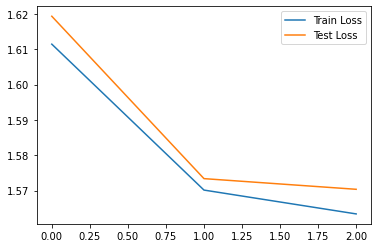

100%|██████████| 674/674 [00:11<00:00, 58.65it/s]



Epoch 4 training done, loss on train set: 1.5499452352523804



100%|██████████| 85/85 [00:02<00:00, 34.43it/s]



Epoch 4 testing done, loss on test set: 1.5765858888626099



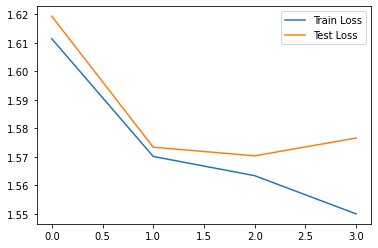

100%|██████████| 674/674 [00:08<00:00, 80.37it/s]



Epoch 5 training done, loss on train set: 1.5427289009094238



100%|██████████| 85/85 [00:01<00:00, 69.91it/s]


Epoch 5 testing done, loss on test set: 1.5655815601348877



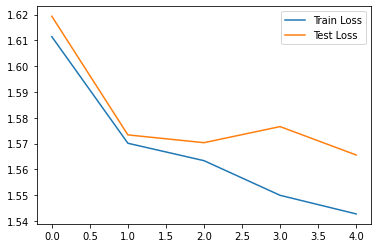

100%|██████████| 674/674 [00:08<00:00, 84.12it/s]



Epoch 6 training done, loss on train set: 1.5325543880462646



100%|██████████| 85/85 [00:01<00:00, 70.60it/s]



Epoch 6 testing done, loss on test set: 1.5367884635925293



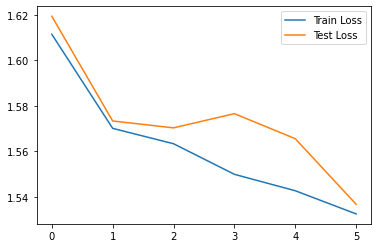

100%|██████████| 674/674 [00:07<00:00, 87.80it/s]



Epoch 7 training done, loss on train set: 1.5258233547210693



100%|██████████| 85/85 [00:01<00:00, 70.83it/s]


Epoch 7 testing done, loss on test set: 1.5339646339416504



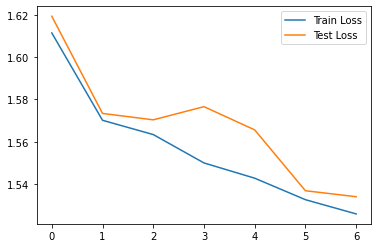

100%|██████████| 674/674 [00:07<00:00, 87.97it/s]



Epoch 8 training done, loss on train set: 1.5173888206481934



100%|██████████| 85/85 [00:01<00:00, 72.28it/s]


Epoch 8 testing done, loss on test set: 1.5847440958023071



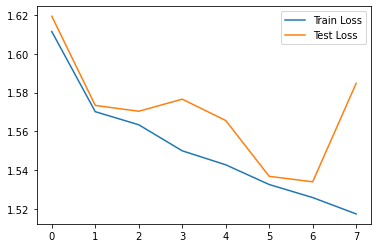

100%|██████████| 674/674 [00:07<00:00, 87.89it/s]



Epoch 9 training done, loss on train set: 1.5124943256378174



100%|██████████| 85/85 [00:01<00:00, 71.79it/s]


Epoch 9 testing done, loss on test set: 1.5193661451339722



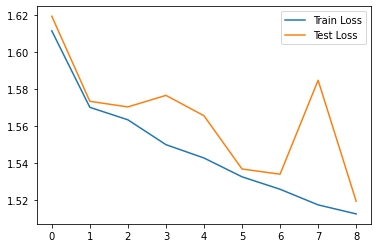

100%|██████████| 674/674 [00:07<00:00, 88.35it/s]



Epoch 10 training done, loss on train set: 1.5067466497421265



100%|██████████| 85/85 [00:01<00:00, 67.35it/s]


Epoch 10 testing done, loss on test set: 1.5212140083312988



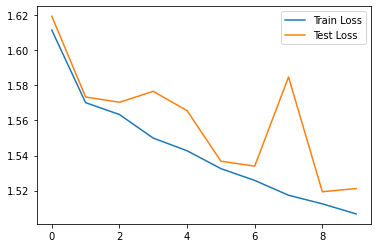

In [255]:
# Lets now train and test our model for multiple epochs:

train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(n_epochs):
  # Training:
  losses = train_model(model, train_sampler, optimizer, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
  fig, ax = plt.subplots()
  ax.plot([i.cpu().detach().numpy() for i in mean_losses_train], label='Train Loss')
  ax.plot([i.cpu().detach().numpy() for i in mean_losses_test], label='Test Loss')
  ax.legend()
  plt.show();

# Evaluating our model
Example Accuracy

In [256]:
model.eval()
# We need to make sure we do not update our model based on the test data:
with torch.no_grad():
  correct = 0
  count = 0
  for (x, y) in tqdm(test_sampler):
    # Making sure our samples are stored on the same device as our model:
    x = x.to(device)
    y = y.to(device)
    prediction = model.forward(x).argmax(axis=1)
    correct += sum(prediction == y)
    count += len(y)
accuracy = (correct/count).detach().cpu().numpy()
print(f'\nAccuracy of model on test set: {accuracy}')

100%|██████████| 85/85 [00:01<00:00, 61.82it/s]


Accuracy of model on test set: 0.39774346351623535


# Obtain predicted and test values

In [257]:
def y_value_gen(model, train_sampler):
        '''
        function that returns a list of true and predicted values
        when given a model and the train/test train_sampler
        '''
        model.eval()
        # We need to make sure we do not update our model based on the test data:
        with torch.no_grad():

                #create lists that store true and pred labels
                y_pred = []
                y_true = []

                # iterate over train data batch
                for inputs, labels in tqdm(train_sampler):
                        inputs, labels = inputs.to(device), labels.to(device)
                        output = model(inputs) 

                        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                        y_pred.extend(output) # Save Prediction
                        
                        labels = labels.data.cpu().numpy()
                        y_true.extend(labels) # Save Truth

                return y_true, y_pred

y_true, y_pred = y_value_gen(model, train_sampler)

100%|██████████| 674/674 [00:05<00:00, 129.92it/s]


# Building a confusion matrix 

In [258]:
# Import useful libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [259]:
def confusion_matrix_gen(y_true, y_pred, cmap=str):

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        target_names = [items[1] for items in class_labels.items()]

        df_cm = pd.DataFrame(cf_matrix, index = target_names,
                                columns = target_names)
        plt.figure(figsize = (12,7))

        c = 'plt.cm.' + cmap
        sns.heatmap(df_cm, annot=True, fmt='g', cmap=eval(c))
        plt.ylabel('True Label', weight='bold', size=12)
        plt.xlabel('Predicted Label', weight='bold',size=12)
        plt.title('Confusion Matrix of True vs Predited Labels', weight='bold', size=16)
        plt.savefig('output.png')



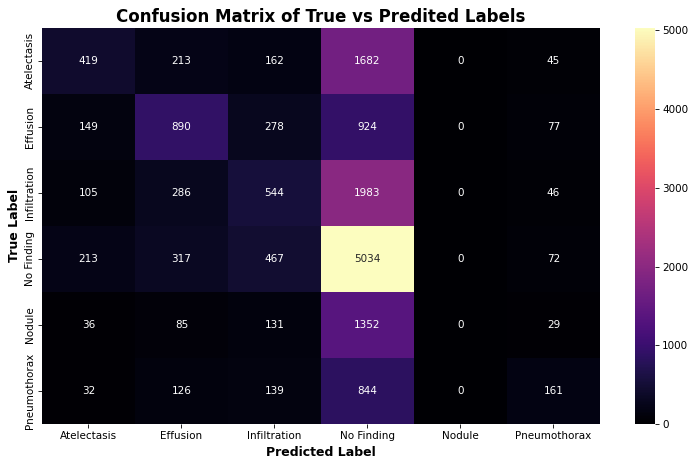

In [260]:
# Confusion matrix for the test data
confusion_matrix_gen(y_true, y_pred, 'magma')

100%|██████████| 85/85 [00:02<00:00, 40.15it/s]


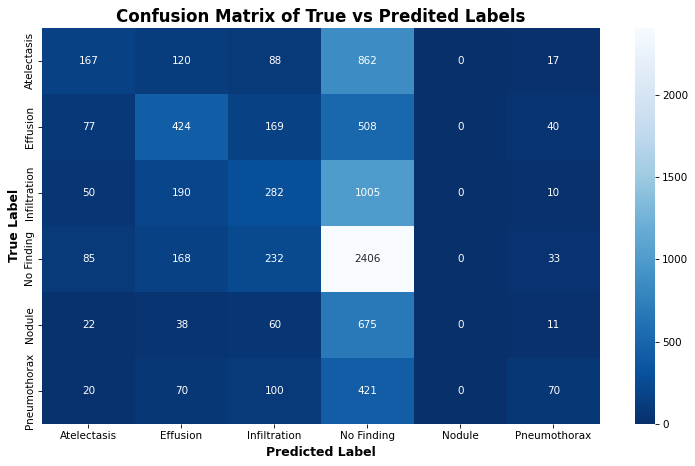

In [261]:
# Confusion matrix for the train data
y_true_test, y_pred_test = y_value_gen(model, test_sampler)
confusion_matrix_gen(y_true_test, y_pred_test, 'Blues_r')

# More metrics evalutaion
Using TorchMetrics

In [262]:
acc = torchmetrics.Accuracy()
f1_score = torchmetrics.F1()
precision = torchmetrics.Precision(num_classes=6, average='micro')   #calculate precision globally across all samples and classes
recall = torchmetrics.Recall(num_classes=6,average='macro')

### Function that generates ROC curve for all labels

In [263]:
def roc_curve_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and generates a roc curve for each class label
    '''
    
    fpr = dict()
    tpr = dict()
    threshold = dict()

    target_names = [items[1] for items in class_labels.items()]

    for i in range(len(class_labels)):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_true, y_pred, pos_label=i)

    
    mpl.rcParams['figure.dpi'] = 100
    # Plot ROC curve
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label="ROC Curve of {label}".format(label=target_names[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()



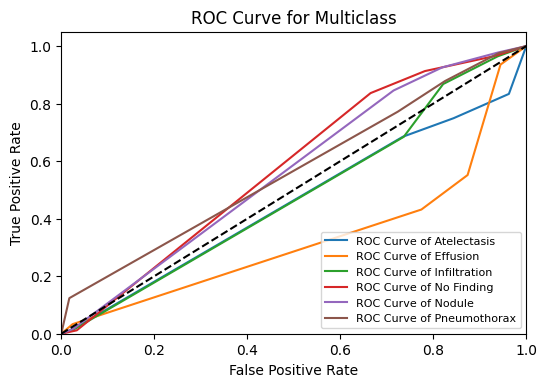

In [264]:
roc_curve_gen(y_true, y_pred)

### Additional metrics per label

In [265]:
def metrics_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and returns a summarised metrics report
    '''
    target_names = [items[1] for items in class_labels.items()]
    return metrics.classification_report(y_true, y_pred, output_dict=True, target_names=target_names, zero_division=1)

metrics_gen(y_true, y_pred)

{'Atelectasis': {'precision': 0.4392033542976939,
  'recall': 0.16620388734629116,
  'f1-score': 0.24115107913669065,
  'support': 2521},
 'Effusion': {'precision': 0.46426708398539385,
  'recall': 0.3839516824849008,
  'f1-score': 0.42030696576151116,
  'support': 2318},
 'Infiltration': {'precision': 0.31609529343404996,
  'recall': 0.18353576248313092,
  'f1-score': 0.23223052294557098,
  'support': 2964},
 'No Finding': {'precision': 0.4259243590828327,
  'recall': 0.8248402425036867,
  'f1-score': 0.5617676598593906,
  'support': 6103},
 'Nodule': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1633},
 'Pneumothorax': {'precision': 0.3744186046511628,
  'recall': 0.12365591397849462,
  'f1-score': 0.18591224018475752,
  'support': 1302},
 'accuracy': 0.4185024642242147,
 'macro avg': {'precision': 0.5033181159085223,
  'recall': 0.280364581466084,
  'f1-score': 0.27356141131465345,
  'support': 16841},
 'weighted avg': {'precision': 0.4655435302737067,
  'recall': 0.

In [266]:
if accuracy >= 0.39:
    torch.save(model,'tom_40.pt')    